In [1]:
%run ../setup.py

In [2]:
t, y = np.loadtxt('../data/10080943_lc.txt', usecols=(0,1)).T

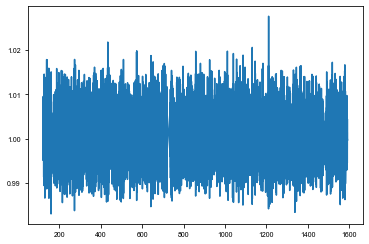

In [3]:
plt.plot(t,y)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c24168f28>,
      dtype=object)

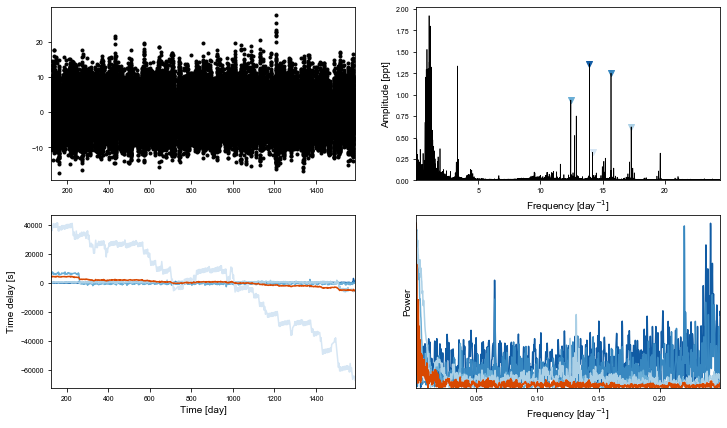

In [4]:
ms = Maelstrom(t, y, freq=np.array([13.94758557, 15.68333011, 
                                    12.45257641, 
#                                     12.89053954, 
                                    17.30504092, 
                                    14.20333404
                                   ]))
ms.first_look(segment_size=2)

In [5]:
import theano
def profile_model(model):
    with model:
        func = xo.utils.get_theano_function_for_var(model.logpt, profile=True)
    #     func = xo.utils.get_theano_function_for_var(theano.grad(model.logpt, model.vars), profile=True)
        args = xo.utils.get_args_for_theano_function(model.test_point)
        print(func(*args))
        %timeit func(*args)

In [6]:
freq = ms.freq
time, flux = ms.time, ms.flux

In [7]:
period_guess = 15.334

In [8]:
def get_phase(nu, t, y):
    arg = 2*np.pi*nu[None, :]*t[:, None]
    D = np.concatenate((np.sin(arg), np.cos(arg),
                        np.ones((len(t), 1))), axis=1)
    DT = D.T
    DTD = np.dot(DT, D)
    w = np.linalg.solve(DTD, np.dot(D.T, y))
    return np.arctan2(w[:len(nu)], w[len(nu):2*len(nu)]) / (2*np.pi*nu)

In [9]:
import tqdm
t0s = np.arange(time.min(), time.max(), 3.5)
phases = np.empty((len(t0s)-1, len(freq)))
phases[:] = np.nan
for i, t0 in tqdm.tqdm(enumerate(t0s[:-1]), total=len(t0s)-1):
    m = (t0 <= time) & (time < t0s[i+1])
    if m.sum() < 100:
        continue
    phases[i] = get_phase(freq, time[m], flux[m])
    
# phases -= np.nanmean(phases, axis=0)
full = np.mean(phases, axis=1)

100%|██████████| 420/420 [00:00<00:00, 2394.79it/s]


Text(0, 0.5, 'power')

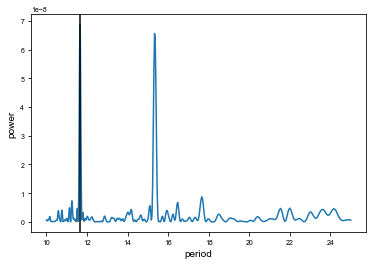

In [10]:
m = np.isfinite(phases[:, 0])
res = xo.estimators.lomb_scargle_estimator(t0s[:-1][m], phases[m, 0], min_period=10, max_period=25)
f, p = res["periodogram"]
plt.plot(1 / f, p)
plt.axvline(res["peaks"][0]["period"], color="k")
plt.xlabel("period")
plt.ylabel("power")

In [11]:
##### period_guess = res["peaks"][0]["period"]
arg = 2*np.pi*t0s[:-1][m]/period_guess
D = np.concatenate((np.sin(arg)[:, None],
                    np.cos(arg)[:, None],
                    np.ones((len(phases[m]), 1))), axis=-1)
w = np.linalg.solve(np.dot(D.T, D), np.dot(D.T, phases[m, 0]))
a_guess = np.sqrt(np.sum(w[:2]**2)) * 86400
period_guess, a_guess

(15.334, 44.105315516695754)

In [21]:
def dft_phase(x, y, freq):
    freq = np.asarray(freq)
    x = np.array(x)
    y = np.array(y)
    phase = []
    for f in freq:
        expo = 2.0 * np.pi * f * x
        ft_real = np.sum(y * np.cos(expo))
        ft_imag = np.sum(y * np.sin(expo))
        phase.append(np.arctan2(ft_imag,ft_real))
    return phase

In [128]:
from astropy.stats import LombScargle

freq = ms.freq[:1]
segment_size=4

uHz_conv = 1e-6 * 24 * 60 * 60
time_0 = time[0]
time_slice, mag_slice, phase = [], [], []
time_delays, time_midpoints = [], []

# Iterate over lightcurve
for t, y in zip(time, flux):
    time_slice.append(t)
    mag_slice.append(y)

    # In each segment
    if t - time_0 > segment_size:
        # Append the time midpoint
        time_midpoints.append(np.mean(time_slice))

        # And the phases for each frequency
        phase.append(dft_phase(time_slice, mag_slice, freq))
        time_0 = t
        time_slice, mag_slice = [], []

phase = np.array(phase).T
# Phase wrapping patch
for ph, f in zip(phase, freq):
    mean_phase = np.mean(ph)
    ph[np.where(ph - mean_phase > np.pi/2)] -= np.pi
    ph[np.where(ph - mean_phase < -np.pi/2)] += np.pi
    ph -= np.mean(ph)
#     ph = np.unwrap(ph)
#     ph -= np.mean(ph)

    td = ph / (2*np.pi*(f / uHz_conv * 1e-6))
    time_delays.append(td)
    
weights = ms.get_weights()


#|plt.scatter(time_midpoints,np.average(time_delays,axis=0, weights=weights))

#td_time, td_td = time_midpoints,np.average(time_delays,axis=0, weights=weights)
#nu_arr = freq

td_time, td_td = np.array(time_midpoints), np.array(time_delays[0])


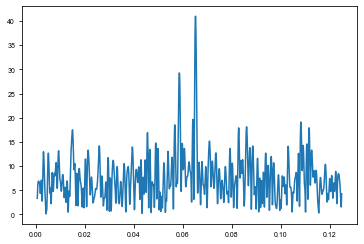

In [129]:
from maelstrom.utils import amplitude_spectrum
plt.plot(*amplitude_spectrum(td_time, td_td))

In [8]:
period_guess, a_guess

NameError: name 'a_guess' is not defined

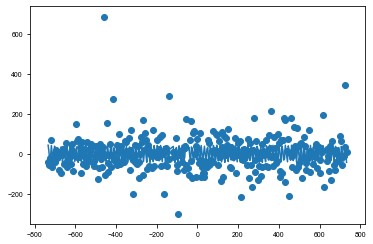

In [131]:
import theano.tensor as tt

with pm.Model() as subdivide_model:
    logP = pm.Normal("logP", mu=np.log(period_guess), sd=1.0, testval=np.log(period_guess))
    period = pm.Deterministic("period", pm.math.exp(logP))
    
    # The time of conjunction
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux)), sd=10, testval=0.)
    logasini = pm.Normal('logasini', mu=np.log(a_guess), sd=100, testval=np.log(a_guess))
    asini = pm.Deterministic("asini", tt.exp(logasini))
    #drift = pm.Normal('drift', mu=0., sd=0.1, testval=0)
    # Periastron sampled from uniform angle
    omega = xo.distributions.Angle("omega", testval=0.)
    # Eccentricity
    eccen = pm.Uniform("eccen", lower=0, upper=0.9, testval=0.4)
    
    # Mean anom
    M = 2.0 * np.pi * td_time / period - phi
    
    # True anom
    kepler_op = xo.theano_ops.kepler.KeplerOp()
    sinf, cosf = kepler_op(M, eccen + np.zeros(len(td_time)))
    
    factor = 1.0 - tt.square(eccen)
    factor /= 1.0 + eccen * cosf
    psi = factor * (sinf*tt.cos(omega)+cosf*tt.sin(omega))
    tau = asini * psi
    #tau += td_time * drift
    taumodel = pm.Deterministic('taumodel', tau - tt.mean(tau))
    
    pm.Normal('obs', mu=taumodel, sd=tt.exp(logs_lc), observed=td_td)
    
    
    plt.plot(td_time, xo.eval_in_model(taumodel))
    plt.scatter(td_time, td_td)

optimizing logp for variables: ['eccen_interval__', 'omega_angle__', 'logasini', 'logs_lc', 'phi_angle__', 'logP']
message: Optimization terminated successfully.
logp: -1552956.9697466996 -> -2043.344834894895


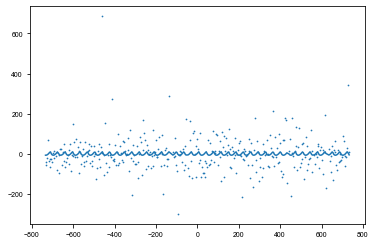

In [132]:
with subdivide_model:
    map_params = xo.optimize()
    
plt.plot(td_time, map_params['taumodel'])
plt.scatter(td_time, td_td, 0.5)

In [133]:
with subdivide_model:
    trace = pm.sample(draws=2000, tune=2000, start=map_params, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eccen, omega, logasini, logs_lc, phi, logP]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:46<00:00, 126.18draws/s]
There were 870 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1266 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [134]:
pm.summary(trace)

/Users/danielhey/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logP,2.771084,1.017372,0.022910,0.819161,4.824065,1529.475332,1.000776
logs_lc,4.437679,0.037840,0.001037,4.364070,4.511923,1173.999906,1.002163
logasini,-75.554711,58.183596,1.955525,-191.449743,1.698473,732.485433,1.001316
period,27.216578,40.893987,1.109459,0.619238,86.051344,944.219271,1.002322
phi,-0.066128,1.813855,0.062282,-2.845382,3.135541,824.367141,1.000399
...,...,...,...,...,...,...,...
taumodel__349,0.004195,0.119799,0.003337,-0.001140,0.001676,1303.514121,1.000677
taumodel__350,-0.002537,0.154774,0.003938,-0.001462,0.000915,1551.670392,0.999899
taumodel__351,-0.001918,0.175921,0.004991,-0.000998,0.001621,1236.383427,0.999856
taumodel__352,0.000219,0.188679,0.005447,-0.000891,0.001864,1206.763471,0.999909


## Models

In [13]:
ms.setup_orbit_model(period=period_guess, eccen=0.47)
opt = ms.optimize()

In [14]:
opt

{'logperiod': array(2.73053787),
 't0': array(0.49654837),
 'varpi_angle__': array([0.83525369, 4.39344434]),
 'eccen_interval__': array(-0.20682156),
 'logs': array(1.51215339),
 'lighttime': array([ 52.20864992, -37.64615783, -35.56717893, -28.53230975,
         29.41235947]),
 'mean_flux': array(0.00012453),
 'W_hat_cos': array([ 1.05615788, -0.3912064 ,  0.13655854,  0.31699801,  0.12838193]),
 'W_hat_sin': array([ 0.8571584 , -1.18934949,  0.9289057 , -0.53767323,  0.30497903]),
 'period': array(15.3411364),
 'varpi': array(0.18787162),
 'eccen': array(0.44847916),
 'tref': array(-0.92236873)}

In [15]:
lt = opt['lighttime']

lt_ivar = np.arange(len(ms.freq)).astype(np.int32)
chi = lt * np.sqrt(lt_ivar)
mask_lower = chi < -1.0        
mask_upper = chi > 1.0

if np.any(mask_lower) and np.any(mask_upper):
    m1 = lt >= 0
    m2 = ~m1
    lt = np.array([
        np.sum(lt_ivar[m1]*lt[m1]) / np.sum(lt_ivar[m1]),
        np.sum(lt_ivar[m2]*lt[m2]) / np.sum(lt_ivar[m2]),
    ])
    inds = 1 - m1.astype(np.int32)
else:
    inds = np.zeros(len(lt), dtype=np.int32)
    lt = np.array([np.sum(lt_ivar*lt) / np.sum(lt_ivar)])
pinned_lt = lt


nu_arr_negative = ms.freq[np.where(inds==1)]
nu_arr_positive = ms.freq[np.where(inds==0)]

In [16]:
pinned_lt

array([ 29.41235947, -32.39624082])

In [17]:
pinned_lt = np.array([45, -45])

In [19]:
from exoplanet.orbits import get_true_anomaly
import theano.tensor as tt
from maelstrom.orbit import Orbit

with pm.Model() as model:
    logP = pm.Bound(pm.Normal,
                    lower=np.log(5),
                    upper=np.log(50))("logP", mu=np.log(opt['period']), sd=10,
                                      testval=np.log(opt['period']))
    period = pm.Deterministic("period", pm.math.exp(logP))
    
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=0.0001*np.log(np.std(flux)), sd=10, testval=0.)
    
#     a1sini = pm.Normal("a1sini", mu=pinned_lt[0], sd=15, testval=pinned_lt[0])
#     a2sini = pm.Normal("a2sini", mu=pinned_lt[1], sd=15, testval=pinned_lt[1])
    
    asini = pm.Uniform("a1sini", lower=-60, upper=60, testval=0., shape=len(ms.freq))
    
    nu = pm.Normal('nu1', mu=ms.freq, sd=0.001, testval=ms.freq, shape=len(ms.freq))
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1., testval=0.00)
    omega = xo.distributions.Angle("omega", testval=opt['varpi'])
    eccen = pm.Uniform("eccen", lower=0, upper=1-1e-3, testval=opt['eccen'])
    
    orbit = Orbit(period=period, 
                  lighttime=asini, 
                  omega=omega, 
                  eccen=eccen, 
                  phi=phi, 
                  freq=nu,
                 with_rv=True,
                 gammav=0.)
    
    full_lc = orbit.get_lightcurve_model(time, flux) + mean
#     # GP parameters
    logw0 = pm.Normal("logw0", mu=np.log(2*np.pi/10), sd=100,
                                                testval=np.log(2*np.pi/10))
    logpower = pm.Normal("logpower", mu=np.log(np.var(flux)), sd=100)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
    gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
    
    pm.Potential("obs", gp.log_likelihood(flux - full_lc))
#     pm.Normal('obs', mu=full_lc, sd=tt.exp(logs_lc), observed=flux)


# from maelstrom.utils import amplitude_spectrum
# with model:
#     full_lc = xo.eval_in_model(orbit1.get_lightcurve_model(time, flux) + orbit2.get_lightcurve_model(time, flux) + mean)
#     plt.plot(*amplitude_spectrum(time, full_lc))
#     plt.plot(*amplitude_spectrum(time, xo.eval_in_model(gp.predict())))
    
#     plt.plot(*amplitude_spectrum(time, flux), alpha=0.2)

In [20]:
with model:
    all_but = [v for v in model.vars if v.name not in ["logP_interval__", "logasini_interval__"]]
    print(all_but)
    
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logs_lc])
    map_params = xo.optimize(start=map_params, vars=[logpower, logw0])
    map_params = xo.optimize(start=map_params, vars=[omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[nu])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    map_params = xo.optimize(start=map_params, vars=[asini])
    map_params = xo.optimize(start=map_params, vars=all_but)

    map_params = xo.optimize(start=map_params, vars=[logP])
    map_params = xo.optimize(start=map_params, vars=all_but)
    map_params = xo.optimize(start=map_params, vars=[asini])
#     map_params = xo.optimize(start=map_params)

[phi_angle__, logs_lc, a1sini_interval__, nu1, mean, omega_angle__, eccen_interval__, logw0, logpower]


optimizing logp for variables: [mean]
5it [00:00,  8.35it/s, logp=-3.756522e+05]
message: Optimization terminated successfully.
logp: -375652.26780784485 -> -375652.2475115874
optimizing logp for variables: [logs_lc]
10it [00:00, 18.53it/s, logp=-1.897312e+05]
message: Optimization terminated successfully.
logp: -375652.2475115874 -> -189731.17655633183
optimizing logp for variables: [logw0, logpower]
17it [00:01, 16.94it/s, logp=-1.667587e+05]
message: Optimization terminated successfully.
logp: -189731.17655633183 -> -166758.74217577124
optimizing logp for variables: [omega]
10it [00:00, 17.09it/s, logp=-1.667383e+05]
message: Optimization terminated successfully.
logp: -166758.74217577124 -> -166738.2848530357
optimizing logp for variables: [phi]
10it [00:00, 16.01it/s, logp=-1.667178e+05]
message: Optimization terminated successfully.
logp: -166738.2848530357 -> -166717.82753030016
optimizing logp for variables: [nu1]
57it [00:02, 19.24it/s, logp=-1.667178e+05]
message: Desired err

In [21]:
map_params

{'logP_interval__': array(-0.05276921),
 'phi_angle__': array([-2.71143646,  3.5564847 ]),
 'logs_lc': array(0.15258846),
 'a1sini_interval__': array([-2.18610725,  1.63041442,  1.66501735,  1.23686051, -1.40145192]),
 'nu1': array([13.94758546, 15.68333006, 12.45257772, 17.30504165, 14.20333423]),
 'mean': array(-0.00695397),
 'omega_angle__': array([ 0.85179878, -4.3902924 ]),
 'eccen_interval__': array(-0.12308814),
 'logw0': array(2.06975683),
 'logpower': array(9.50999162),
 'logP': array(2.73036111),
 'period': array(15.33842485),
 'phi': array(-0.65138511),
 'a1sini': array([-47.87939781,  40.34716828,  40.90924477,  33.00204819,
        -36.28970224]),
 'omega': array(2.94995491),
 'eccen': array(0.46879749),
 'logS0': array(1.23096431)}

In [58]:
from exoplanet.orbits import get_true_anomaly
import theano.tensor as tt

with pm.Model() as model:
    logP = pm.Bound(pm.Normal,
                    lower=np.log(5),
                    upper=np.log(50))("logP", mu=np.log(opt['period']), sd=10,
                                      testval=np.log(opt['period']))
    period = pm.Deterministic("period", pm.math.exp(logP))
    
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=0.0001*np.log(np.std(flux)), sd=10, testval=0.)
    
#     a1sini = pm.Normal("a1sini", mu=pinned_lt[0], sd=15, testval=pinned_lt[0])
#     a2sini = pm.Normal("a2sini", mu=pinned_lt[1], sd=15, testval=pinned_lt[1])
    
    a1sini = pm.Uniform("a1sini", lower=-60, upper=60, testval=pinned_lt[0])
    a2sini = pm.Uniform("a2sini", lower=-60, upper=60, testval=pinned_lt[1])
    
    nu1 = pm.Normal('nu1', mu=nu_arr_positive, sd=0.001, testval=nu_arr_positive, shape=len(nu_arr_positive))
    nu2 = pm.Normal('nu2', mu=nu_arr_negative, sd=0.001, testval=nu_arr_negative, shape=len(nu_arr_negative))
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1., testval=0.00)
    omega = xo.distributions.Angle("omega", testval=opt['varpi'])
    eccen = pm.Uniform("eccen", lower=0, upper=1-1e-3, testval=opt['eccen'])
    
    orbit1 = Orbit(period=period, 
                  lighttime=a1sini, 
                  omega=omega, 
                  eccen=eccen, 
                  phi=phi, 
                  freq=nu1,
                 with_rv=True,
                 gammav=0.)
    
    orbit2 = Orbit(period=period, 
              lighttime=a2sini, 
              omega=omega, 
              eccen=eccen, 
              phi=phi, 
              freq=nu2,
             with_rv=True,
             gammav=0.)
    full_lc = orbit1.get_lightcurve_model(time, flux) + orbit2.get_lightcurve_model(time, flux) + mean
#     # GP parameters
    logw0 = pm.Normal("logw0", mu=np.log(2*np.pi/10), sd=100,
                                                testval=np.log(2*np.pi/10))
    logpower = pm.Normal("logpower", mu=np.log(np.var(flux)), sd=100)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
    gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
    
    pm.Potential("obs", gp.log_likelihood(flux - full_lc))
#     pm.Normal('obs', mu=full_lc, sd=tt.exp(logs_lc), observed=flux)


# from maelstrom.utils import amplitude_spectrum`
# with model:
#     full_lc = xo.eval_in_model(orbit1.get_lightcurve_model(time, flux) + orbit2.get_lightcurve_model(time, flux) + mean)
#     plt.plot(*amplitude_spectrum(time, full_lc))
#     plt.plot(*amplitude_spectrum(time, xo.eval_in_model(gp.predict())))
    
#     plt.plot(*amplitude_spectrum(time, flux), alpha=0.2)

In [59]:
with model:
    all_but = [v for v in model.vars if v.name not in ["logP_interval__", "logasini_interval__"]]
    print(all_but)
    
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logs_lc])
    map_params = xo.optimize(start=map_params, vars=[logpower, logw0])
    map_params = xo.optimize(start=map_params, vars=[omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[nu1, nu2])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    map_params = xo.optimize(start=map_params, vars=[a1sini, a2sini])
    map_params = xo.optimize(start=map_params, vars=all_but)

    map_params = xo.optimize(start=map_params, vars=[logP])
    map_params = xo.optimize(start=map_params, vars=all_but)
    map_params = xo.optimize(start=map_params, vars=[a1sini, a2sini])
#     map_params = xo.optimize(start=map_params)

[phi_angle__, logs_lc, a1sini_interval__, a2sini_interval__, nu1, nu2, mean, omega_angle__, eccen_interval__, logw0, logpower]


optimizing logp for variables: [mean]
5it [00:00, 14.44it/s, logp=-3.755878e+05]
message: Optimization terminated successfully.
logp: -375587.7932657327 -> -375587.77287921746
optimizing logp for variables: [logs_lc]
10it [00:00, 16.14it/s, logp=-1.897250e+05]
message: Optimization terminated successfully.
logp: -375587.77287921746 -> -189724.96580000242
optimizing logp for variables: [logw0, logpower]
16it [00:01, 15.87it/s, logp=-1.667492e+05]
message: Optimization terminated successfully.
logp: -189724.96580000242 -> -166749.20077684356
optimizing logp for variables: [omega]
89it [00:06, 14.78it/s, logp=-1.667282e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: -166749.20077684356 -> -166728.17278381056
optimizing logp for variables: [phi]
13it [00:00, 13.32it/s, logp=-1.667077e+05]
message: Optimization terminated successfully.
logp: -166728.17278381056 -> -166707.70834156446
optimizing logp for variables: [nu2, nu1]
63it [00:04, 14.38it/s, logp=-1.

In [60]:
map_params

{'logP_interval__': array(-0.05282949),
 'phi_angle__': array([-2.87721088,  3.42369056]),
 'logs_lc': array(0.15257527),
 'a1sini_interval__': array(-2.42613517),
 'a2sini_interval__': array(1.84776838),
 'nu1': array([13.94758544, 14.20333421]),
 'nu2': array([15.68333006, 12.45257773, 17.30504159]),
 'mean': array(-0.00694822),
 'omega_angle__': array([ 1.08002644, -4.33976298]),
 'eccen_interval__': array(0.21452039),
 'logw0': array(2.06975994),
 'logpower': array(9.51000028),
 'logP': array(2.73032643),
 'period': array(15.33789295),
 'phi': array(-0.69888426),
 'a1sini': array(-50.25583834),
 'a2sini': array(43.66378469),
 'omega': array(2.89768005),
 'eccen': array(0.55287195),
 'logS0': array(1.23096054)}

In [61]:
rv_jd_a, rv_rv_a, rv_err_a = np.loadtxt('../../data/kic10080943a_JDrv.txt', delimiter=',', usecols=(0,1,2)).T
rv_jd_a += 2400000
rv_jd_a -= 2454833

rv_jd_b, rv_rv_b, rv_err_b = np.loadtxt('../../data/kic10080943b_JDrv.txt', delimiter=',', usecols=(0,1,2)).T
rv_jd_b += 2400000
rv_jd_b -= 2454833

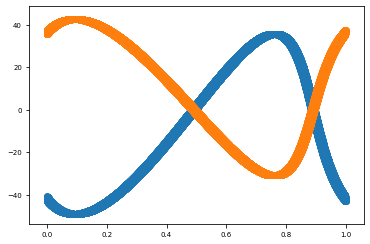

In [62]:
with model:
    plt.scatter(time % 15.34003849 / 15.34003849, xo.eval_in_model(orbit1.get_time_delay(time), map_params)*86400)
    plt.scatter(time % 15.34003849 / 15.34003849, xo.eval_in_model(orbit2.get_time_delay(time), map_params)*86400)

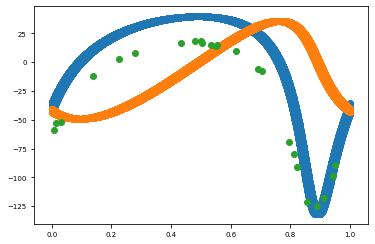

In [63]:
with model:
    plt.scatter(time % 15.34003849 / 15.34003849, xo.eval_in_model(orbit1.get_radial_velocity(time), map_params))
    plt.scatter(time % 15.34003849 / 15.34003849, xo.eval_in_model(orbit1.get_time_delay(time), map_params)*86400)
    plt.scatter(rv_jd_a % 15.34003849 / 15.34003849, rv_rv_a)

In [64]:
sampler = xo.PyMC3Sampler(window=50, finish=500)
with model:
    burnin = sampler.tune(tune=1000, step_kwargs=dict(target_accept=0.9), start=map_params)

Sampling 4 chains:  12%|█▏        | 36/308 [02:05<15:48,  3.49s/draws]


ValueError: Not enough samples to build a trace.

In [ ]:
with model:
    trace = sampler.sample(draws=1000)

In [ ]:
pm.summary(trace)

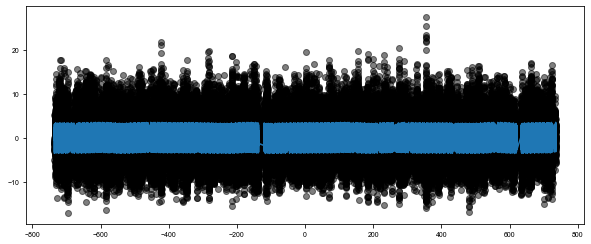

In [62]:
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt

mag = flux
with pm.Model() as model:
    # It's much faster to sample from a log-space period
#     logP = pm.Normal("logP", mu=np.log(9.15), sd=3.)
    logP = pm.Bound(pm.Normal,
                    lower=np.log(5),
                    upper=np.log(50))("logP", mu=np.log(period_guess), sd=1.0,
                                      testval=np.log(period_guess))
    period = pm.Deterministic("period", pm.math.exp(logP))
#     drift_gradient = pm.Normal('drift_grad', mu=0.0, sd=0.01, shape=len(freq))
    
    # The time of conjunction
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(mag)), sd=10, testval=0.)
    asini = pm.Uniform('asini', lower=-100, upper=100, shape=len(freq))
        
    # Periastron sampled from uniform angle
    omega = xo.distributions.Angle("omega", testval=0.)
    # Eccentricity
    eccen = pm.Uniform("eccen", lower=0, upper=0.9, testval=0.44)
    
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.003)
    
    # Mean anom
    M = 2.0 * np.pi * time / period - phi
    # True anom
    kepler_op = xo.theano_ops.kepler.KeplerOp()
    sinf, cosf = kepler_op(M, eccen + np.zeros(len(time)))
    
    factor = 1.0 - tt.square(eccen)
    factor /= 1.0 + eccen * cosf
    psi = -factor * (sinf*tt.cos(omega)+cosf*tt.sin(omega))
    
    # Sampling in the weights parameter is faster than solving the matrix.
    lognu = pm.Normal("lognu", mu=np.log(freq), sd=0.1, shape=len(freq))
    nu = pm.Deterministic("nu", tt.exp(lognu))
    factor = 2. * np.pi * nu
    
    arg = ((factor * (1))[None, :] * time[:, None]
           - (factor * asini / 86400)[None, :] * psi[:, None])
    
#     W_hat_cos = pm.Normal("W_hat_cos", mu=0.0, sd=0.01, shape=len(freq))
#     W_hat_sin = pm.Normal("W_hat_sin", mu=0.0, sd=0.01, shape=len(freq))
#     model_tensor = tt.dot(tt.cos(arg), W_hat_cos[:, None])
#     model_tensor += tt.dot(tt.sin(arg), W_hat_sin[:, None])
#     lc_model = tt.squeeze(model_tensor)

    phase = xo.distributions.Angle("phase", shape=len(freq))
    log_mean_amp = np.log(ms.get_weights(norm=False))
    logamp = pm.Normal("logamp", mu=log_mean_amp, sd=1, shape=len(freq),
                                         testval=log_mean_amp)
    lc_model = tt.sum(tt.exp(logamp)[None, :] * tt.sin(arg - phase[None, :]), axis=1)
        
    # GP parameters
    logw0 = pm.Bound(pm.Normal,
                     lower=np.log(2*np.pi/100.0),
                     upper=np.log(2*np.pi/2.0))("logw0", mu=np.log(2*np.pi/10), sd=10,
                                                testval=np.log(2*np.pi/10))
    logpower = pm.Normal("logpower", mu=np.log(np.var(mag)), sd=10)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
    gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
    
    full_lc = lc_model + mean
#     pm.Normal("obs", mu=full_lc, sd=tt.exp(logs_lc), observed=mag)

#     mag_sim = xo.eval_in_model(full_lc) + np.median(np.abs(np.diff(mag))) * np.random.randn(len(time))

    pm.Potential("obs", gp.log_likelihood(mag - full_lc))
#     pm.Deterministic("gp_pred", gp.predict())


    
fig, axes = plt.subplots(1,1, figsize=[10,4])
with model:
    
    ax = axes
    ax.plot(time, xo.eval_in_model(lc_model))
    plt.scatter(time,mag, c='black', alpha=0.5)

[phi_angle__, logs_lc, asini_interval__, omega_angle__, eccen_interval__, mean, lognu, phase_angle__, logamp, logw0_interval__, logpower]
optimizing logp for variables: ['mean']
message: Optimization terminated successfully.
logp: -458951.7304088613 -> -458951.7016170789
optimizing logp for variables: ['logs_lc']
message: Optimization terminated successfully.
logp: -458951.7016170789 -> -194268.0810095644
optimizing logp for variables: ['logw0_interval__', 'logpower']
message: Optimization terminated successfully.
logp: -194268.0810095644 -> -176384.30164858795
optimizing logp for variables: ['logamp', 'phase_angle__']
message: Desired error not necessarily achieved due to precision loss.
logp: -176384.30164858795 -> -172567.85626754
optimizing logp for variables: ['phi_angle__']
message: Optimization terminated successfully.
logp: -172567.85626754 -> -172547.39894480444
optimizing logp for variables: ['lognu']
message: Desired error not necessarily achieved due to precision loss.
logp

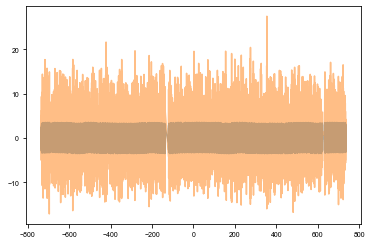

In [63]:
with model:
    all_but = [v for v in model.vars if v.name not in ["logP_interval__", "logasini_interval__"]]
    print(all_but)
    
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logs_lc])
    map_params = xo.optimize(start=map_params, vars=[logpower, logw0])
    map_params = xo.optimize(start=map_params, vars=[phase, logamp])
#     map_params = xo.optimize(start=map_params, vars=[eccen, omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[lognu])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    map_params = xo.optimize(start=map_params, vars=[asini])
    map_params = xo.optimize(start=map_params, vars=all_but)

    map_params = xo.optimize(start=map_params, vars=[logP])
    map_params = xo.optimize(start=map_params, vars=all_but)

#     map_params = xo.optimize(start=map_params)

    plt.plot(time, xo.eval_in_model(lc_model, map_params), alpha=0.5)
    plt.plot(time, mag, alpha=0.5)

In [64]:
map_params

{'logP_interval__': array(-0.05359368),
 'phi_angle__': array([2.25830662, 3.860058  ]),
 'logs_lc': array(0.27234156),
 'asini_interval__': array([-1.62101887,  1.28535173,  1.33269864]),
 'omega_angle__': array([ 1.19878762, -4.30847041]),
 'eccen_interval__': array(1.52999842),
 'mean': array(-0.04303898),
 'lognu': array([2.63530639, 2.75259836, 2.52192766]),
 'phase_angle__': array([[-1.69563926,  3.12404092,  1.81045151],
        [ 4.13821405,  3.20005488, -4.08928839]]),
 'logamp': array([ 0.30915005,  0.22543305, -0.06668459]),
 'logw0_interval__': array(9.29310317),
 'logpower': array(9.04308697),
 'logP': array(2.72988684),
 'period': array(15.33115199),
 'phi': array(0.5293504),
 'asini': array([-66.98711941,  56.67187632,  58.25733407]),
 'omega': array(2.870217),
 'eccen': array(0.73980547),
 'nu': array([13.94758524, 15.68332995, 12.45257785]),
 'phase': array([-0.38888444,  0.77337901,  2.72480071]),
 'logw0': array(1.14436979),
 'logS0': array(4.46560781)}

In [44]:
ms.get_weights(norm=False), np.exp(map_params['logamp'])

(array([1.35664138, 1.24918202, 0.93790428]),
 array([1.36230162, 1.25276158, 0.93547694]))

In [45]:
with model:
    val = xo.eval_in_model(asini[:,None] * psi, map_params)
    tt_time = time % map_params['period'] / map_params['period']
    sort = np.argsort(tt_time)

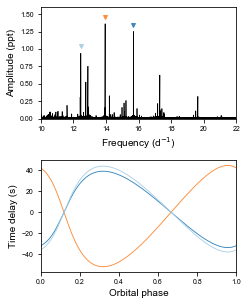

In [46]:
fig, axes = plt.subplots(2,1, figsize=[3.3333,2.06*2], constrained_layout=True)

from maelstrom.utils import unique_colors

ax = axes[1]
pos_td = val[map_params['asini'] > 0]
pos = unique_colors(len(pos_td), cmap='Oranges')[::-1]

neg_td = val[map_params['asini'] < 0]
neg = unique_colors(len(neg_td), cmap='Blues')[::-1]

for td, color in zip(pos_td, pos):
    ax.plot(tt_time[sort], td.T[sort], color=color, linewidth=0.9)

for td, color in zip(neg_td, neg):
    ax.plot(tt_time[sort], td.T[sort], color=color, linewidth=0.9)

ax.set_xlabel('Orbital phase')
ax.set_ylabel('Time delay (s)')
ax.set_xlim(0,1)

from maelstrom.utils import amplitude_spectrum
ax = axes[0]
f,a = amplitude_spectrum(time, flux)
ax.plot(f,a, linewidth=0.7, c='black')
ax.set_xlim(0,24)
ax.set_ylim(0,1.6)
ax.set_xlabel('Frequency (d$^{-1}$)')
ax.set_ylabel('Amplitude (ppt)')
ax.set_xlim(10,22)
weights = ms.get_weights(norm=False)
pos_freq = ms.freq[map_params['asini'] > 0]
pos_weight = weights[map_params['asini'] > 0]
neg_freq = ms.freq[map_params['asini'] < 0]
neg_weight = weights[map_params['asini'] < 0]

for ff, weight, color in zip(pos_freq, pos_weight, pos):
    ax.scatter(ff,weight+0.1,15,color=color, marker='v')
    
for ff, weight, color in zip(neg_freq, neg_weight, neg):
    ax.scatter(ff,weight+0.1,15,color=color, marker='v')
    
#plt.savefig(overleaf_path+'10080943_init_opt.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

In [47]:
opt = map_params

In [48]:
opt

{'logP_interval__': array(-0.05304152),
 'phi_angle__': array([2.84697063, 3.448891  ]),
 'logs_lc': array(0.27237454),
 'asini_interval__': array([ 1.19710235, -0.8571673 , -0.98050136]),
 'omega_angle__': array([-0.68829479,  4.41884616]),
 'mean': array(-0.04298838),
 'lognu': array([2.63530639, 2.75259836, 2.52192766]),
 'phase_angle__': array([[-1.75645807,  3.17034142,  1.76290606],
        [ 4.11276393,  3.15417836, -4.11000361]]),
 'logamp': array([ 0.30917564,  0.22535038, -0.06669878]),
 'logw0_interval__': array(9.29309804),
 'logpower': array(9.04306205),
 'logP': array(2.73020446),
 'period': array(15.33602234),
 'phi': array(0.69008215),
 'asini': array([ 53.60178129, -40.41369651, -45.44153712]),
 'omega': array(-0.15452177),
 'nu': array([13.94758524, 15.68332996, 12.45257786]),
 'phase': array([-0.40362676,  0.78795378,  2.73639752]),
 'logw0': array(1.14436979),
 'logS0': array(4.4655829)}

In [13]:
pinned_lt = [
    53.60178129,
    -43.
]
nu_arr_positive = np.array([
    13.94758524
])
nu_arr_negative = np.array([
    15.68332996, 12.45257786
])

In [49]:
lt = opt['asini']

lt_ivar = np.arange(len(opt['nu'])).astype(np.int32)
chi = lt * np.sqrt(lt_ivar)
mask_lower = chi < -1.0        
mask_upper = chi > 1.0

if np.any(mask_lower) and np.any(mask_upper):
    m1 = lt >= 0
    m2 = ~m1
    lt = np.array([
        np.sum(lt_ivar[m1]*lt[m1]) / np.sum(lt_ivar[m1]),
        np.sum(lt_ivar[m2]*lt[m2]) / np.sum(lt_ivar[m2]),
    ])
    inds = 1 - m1.astype(np.int32)
else:
    inds = np.zeros(len(lt), dtype=np.int32)
    lt = np.array([np.sum(lt_ivar*lt) / np.sum(lt_ivar)])
pinned_lt = lt

# Get frequencies for each star
nu_arr_negative = opt['nu'][np.where(inds==1)]
nu_arr_positive = opt['nu'][np.where(inds==0)]

In [58]:
from exoplanet.orbits import get_true_anomaly
import theano.tensor as tt

with pm.Model() as pb2_model:
    logP = pm.Bound(pm.Normal,
                    lower=np.log(5),
                    upper=np.log(50))("logP", mu=np.log(map_params['period']), sd=10.,
                                      testval=np.log(map_params['period']))
    period = pm.Deterministic("period", pm.math.exp(logP))
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.median(np.abs(np.diff(flux)))), sd=10, testval=np.log(np.median(np.abs(np.diff(flux)))))
    asini_neg = pm.Normal("asini_pos",mu=pinned_lt[0], sd=20, testval=pinned_lt[0])
    asini_pos = pm.Normal("asini_neg",mu=pinned_lt[1], sd=20, testval=pinned_lt[1])
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.)
    
    omega = xo.distributions.Angle("omega")
    eccen = pm.Uniform("eccen", lower=0, upper=1-1e-3, testval=0.444)
    
    M = 2.0 * np.pi * time / period - phi
    # True anom
    f = get_true_anomaly(M, eccen + tt.zeros_like(M))
    psi = - (1 - tt.square(eccen)) * tt.sin(f+omega) / (1 + eccen*tt.cos(f))
    
    lognu_pos = pm.Normal("lognu_pos", mu=np.log(nu_arr_positive), sd=0.1, shape=len(nu_arr_positive))
    nu_pos = pm.Deterministic("nu_pos", tt.exp(lognu_pos))
    lognu_neg = pm.Normal("lognu_neg", mu=np.log(nu_arr_negative), sd=0.1, shape=len(nu_arr_negative))
    nu_neg = pm.Deterministic("nu_neg", tt.exp(lognu_neg))

    #  Positive
#     arg = 2. * np.pi * nu_pos[None, :] * (time[:, None] - (asini_pos / 86400.) * psi[:, None])
#     W_hat_cos_pos = pm.Normal("W_hat_cos_pos", mu=0.0, sd=100.0,shape=len(nu_arr_positive))
#     W_hat_sin_pos = pm.Normal("W_hat_sin_pos", mu=0.0, sd=100.0,shape=len(nu_arr_positive))
#     model_tensor = tt.dot(tt.cos(arg), W_hat_cos_pos[:, None]) + tt.dot(tt.sin(arg), W_hat_sin_pos[:, None])
#     lc_model = tt.squeeze(model_tensor)
    
#     #  Negative
#     arg = 2. * np.pi * nu_neg[None, :] * (time[:, None] - (asini_neg / 86400.) * psi[:, None])
#     W_hat_cos_neg = pm.Normal("W_hat_cos_neg", mu=0.0, sd=100.0,shape=len(nu_arr_negative))
#     W_hat_sin_neg = pm.Normal("W_hat_sin_neg", mu=0.0, sd=100.0,shape=len(nu_arr_negative))
#     model_tensor = tt.dot(tt.cos(arg), W_hat_cos_neg[:, None]) + tt.dot(tt.sin(arg), W_hat_sin_neg[:, None])
#     lc_model += tt.squeeze(model_tensor)

#     # Positive
    arg = 2. * np.pi * nu_pos * (time[:, None] - ((asini_pos) / 86400) * psi[:, None])
    D = tt.concatenate((tt.cos(arg), tt.sin(arg)), axis=-1)
    DT = D.T
    w = tt.slinalg.solve(tt.dot(DT, D), tt.dot(DT, flux))
    lc_model = tt.dot(D, w)
    
    # Negative
    arg = 2. * np.pi * nu_neg * (time[:, None] - ((asini_neg) / 86400) * psi[:, None])
    D = tt.concatenate((tt.cos(arg), tt.sin(arg)), axis=-1)
    DT = D.T
    w = tt.slinalg.solve(tt.dot(DT, D), tt.dot(DT, flux))
    lc_model += tt.dot(D, w)

    #GP parameters
#     logw0 = logw0 = pm.Bound(pm.Normal,
#                      lower=np.log(2*np.pi/100.0),
#                      upper=np.log(2*np.pi/1.0))("logw0", mu=np.log(2*np.pi/10), sd=10,
#                                                 testval=np.log(2*np.pi/10))
#     logpower = pm.Normal("logpower", mu=np.log(np.var(flux)), sd=10)
#     logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
#     kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
#     gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
    
#     full_lc = lc_model + mean
#     gp_l = gp.log_likelihood(flux - full_lc)
#     #Weight likelihood equally with RV data
#     pm.Potential("obs", gp_l)
        
    full_lc = lc_model + mean
    pm.Normal('obs', mu=full_lc, sd=tt.exp(logs_lc), observed=flux)

In [59]:
with pb2_model:
    all_but = [v for v in pb2_model.vars if v.name not in ["logP_interval__"]]
    print(all_but)
    
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logs_lc])
#     map_params = xo.optimize(start=map_params, vars=[logpower, logw0])
#     map_params = xo.optimize(start=map_params, vars=[W_hat_cos_neg, W_hat_cos_pos, W_hat_sin_neg, W_hat_sin_pos])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[lognu_pos, lognu_neg])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    map_params = xo.optimize(start=map_params, vars=[asini_pos, asini_neg])
    map_params = xo.optimize(start=map_params, vars=[omega, eccen])
    map_params = xo.optimize(start=map_params, vars=all_but)

#     map_params = xo.optimize(start=map_params, vars=[logP])
    map_params = xo.optimize(start=map_params, vars=[period])
    map_params = xo.optimize(start=map_params, vars=all_but)
#     map_params = xo.optimize(start=map_params)

[phi_angle__, logs_lc, asini_pos, asini_neg, mean, omega_angle__, eccen_interval__, lognu_pos, lognu_neg]
optimizing logp for variables: ['mean']
message: Optimization terminated successfully.
logp: -264403.4710434688 -> -264403.4703756111
optimizing logp for variables: ['logs_lc']
message: Desired error not necessarily achieved due to precision loss.
logp: -264403.4703756111 -> -191709.93378942844
optimizing logp for variables: ['phi_angle__']
message: Optimization terminated successfully.
logp: -191709.93378942844 -> -191678.5181225986
optimizing logp for variables: ['lognu_neg', 'lognu_pos']
message: Desired error not necessarily achieved due to precision loss.
logp: -191678.5181225986 -> -191678.50112266222
optimizing logp for variables: ['lognu_neg', 'lognu_pos', 'eccen_interval__', 'omega_angle__', 'mean', 'asini_neg', 'asini_pos', 'logs_lc', 'phi_angle__']
message: Desired error not necessarily achieved due to precision loss.
logp: -191678.50112266222 -> -191678.50112266184
opti

In [60]:
map_params

{'logP_interval__': array(-0.05155323),
 'phi_angle__': array([3.85765665, 2.26240394]),
 'logs_lc': array(1.5181755),
 'asini_pos': array(49.06203725),
 'asini_neg': array(-48.97406846),
 'mean': array(0.0003904),
 'omega_angle__': array([-1.0650696 , -4.34345715]),
 'eccen_interval__': array(-0.0423049),
 'lognu_pos': array([2.63530638]),
 'lognu_neg': array([2.75259833, 2.52192753]),
 'logP': array(2.73106061),
 'period': array(15.3491578),
 'phi': array(1.04038398),
 'omega': array(-2.90112501),
 'eccen': array(0.48893593),
 'nu_pos': array([13.94758513]),
 'nu_neg': array([15.6833294 , 12.45257629])}

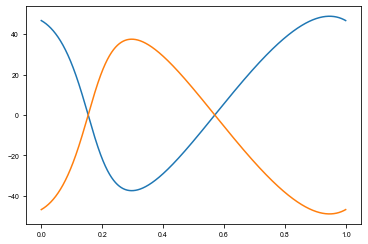

In [61]:
with pb2_model:
    fold_time = time % map_params['period'] / map_params['period']
    sort = np.argsort(fold_time)
    
    td_pos = xo.eval_in_model(asini_pos * psi, map_params)
    td_neg = xo.eval_in_model(asini_neg * psi, map_params)
    
    plt.plot(fold_time[sort], td_pos[sort])
    plt.plot(fold_time[sort], td_neg[sort])

In [103]:
sampler = xo.PyMC3Sampler(window=50, finish=500)
with pb2_model:
    burnin = sampler.tune(tune=1000, step_kwargs=dict(target_accept=0.9), start=map_params)

Sampling 4 chains:  85%|████████▌ | 1962/2308 [6:23:42<1:37:38, 16.93s/draws] 

KeyboardInterrupt



In [ ]:
with pb2_model:
    trace = sampler.sample(draws=1000)

## With RV

In [14]:
rv_jd_a, rv_rv_a, rv_err_a = np.loadtxt('data/kic10080943a_JDrv.txt', delimiter=',', usecols=(0,1,2)).T
rv_jd_a += 2400000
rv_jd_a -= 2454833
rv_jd_a -= ms.time_mid

rv_jd_b, rv_rv_b, rv_err_b = np.loadtxt('data/kic10080943b_JDrv.txt', delimiter=',', usecols=(0,1,2)).T
rv_jd_b += 2400000
rv_jd_b -= 2454833
rv_jd_b -= ms.time_mid

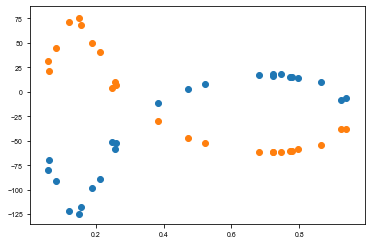

In [15]:
plt.scatter(rv_jd_a % 15.33 / 15.33, rv_rv_a)
plt.scatter(rv_jd_b % 15.33 / 15.33, rv_rv_b)

In [17]:
from exoplanet.orbits import get_true_anomaly
import theano.tensor as tt
import theano

rv_time_tensor_a = theano.shared(rv_jd_a)
rv_rv_tensor_a = theano.shared(rv_rv_a)

rv_time_tensor_b = theano.shared(rv_jd_b)
rv_rv_tensor_b = theano.shared(rv_rv_b)

with pm.Model() as pb2_model_RV:
    logP = pm.Bound(pm.Normal,
                    lower=np.log(5),
                    upper=np.log(50))("logP", mu=np.log(15.3356), sd=5.0,
                                      testval=np.log(15.3356))
    period = pm.Deterministic("period", pm.math.exp(logP))
    
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux)), sd=10, testval=0.)
    asini_pos = pm.Normal("asini_pos",mu=pinned_lt[0], sd=10, testval=pinned_lt[0])
    asini_neg = pm.Normal("asini_neg",mu=pinned_lt[1], sd=10, testval=pinned_lt[1])
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.)
    omega = xo.distributions.Angle("omega")
    eccen = pm.Uniform("eccen", lower=0, upper=1-1e-3, testval=0.444)
    
    M = 2.0 * np.pi * time / period - phi
    # True anom
    f = get_true_anomaly(M, eccen + tt.zeros_like(M))
    psi = - (1 - tt.square(eccen)) * tt.sin(f+omega) / (1 + eccen*tt.cos(f))
    
    lognu_pos = pm.Normal("lognu_pos", mu=np.log(nu_arr_positive), sd=0.1, shape=len(nu_arr_positive))
    nu_pos = pm.Deterministic("nu_pos", tt.exp(lognu_pos))
    lognu_neg = pm.Normal("lognu_neg", mu=np.log(nu_arr_negative), sd=0.1, shape=len(nu_arr_negative))
    nu_neg = pm.Deterministic("nu_neg", tt.exp(lognu_neg))

    # Positive
    arg = 2. * np.pi * nu_pos * (time[:, None] - ((asini_pos) / 86400) * psi[:, None])
    D = tt.concatenate((tt.cos(arg), tt.sin(arg)), axis=-1)
    DT = D.T
    w = tt.slinalg.solve(tt.dot(DT, D), tt.dot(DT, flux))
    lc_model = tt.dot(D, w)
    
    # Negative
    arg = 2. * np.pi * nu_neg * (time[:, None] - ((asini_neg) / 86400) * psi[:, None])
    D = tt.concatenate((tt.cos(arg), tt.sin(arg)), axis=-1)
    DT = D.T
    w = tt.slinalg.solve(tt.dot(DT, D), tt.dot(DT, flux))
    lc_model += tt.dot(D, w)
        
    # GP parameters
#     logw0 = logw0 = pm.Bound(pm.Normal,
#                      lower=np.log(2*np.pi/100.0),
#                      upper=np.log(2*np.pi/1.0))("logw0", mu=np.log(2*np.pi/10), sd=10,
#                                                 testval=np.log(2*np.pi/10))
#     logpower = pm.Normal("logpower", mu=np.log(np.var(flux)), sd=10)
#     logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
#     kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
#     gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
    
    full_lc = lc_model + mean
#     gp_l = gp.log_likelihood(flux - full_lc)
#     #Weight likelihood equally with RV data
#     pm.Potential("obs", gp_l)
    
    
    # RADIAL VELOCITIES
    logs_rv_a = pm.Normal('logs_RV_a', mu=0., sd=10)
    logs_rv_b = pm.Normal('logs_RV_b', mu=0., sd=10)
    gammav = pm.Normal('gammav', mu=0., sd=100.)
    
    # Positive
    rv_mean_anom = (2.0 * np.pi * rv_time_tensor_a / period - phi)
    rv_true_anom = get_true_anomaly(rv_mean_anom, eccen + tt.zeros_like(rv_mean_anom))
    rv_vrad_a = ((asini_pos / 86400) * (-2.0 * np.pi * (1 / period) * (1/tt.sqrt(1.0 - tt.square(eccen))) * (tt.cos(rv_true_anom + omega) + eccen*tt.cos(omega))))
    rv_vrad_a *= 299792.458  # c in km/s
    rv_vrad_a += gammav
    
    # Negative 
    rv_mean_anom = (2.0 * np.pi * rv_time_tensor_b / period - phi)
    rv_true_anom = get_true_anomaly(rv_mean_anom, eccen + tt.zeros_like(rv_mean_anom))
    rv_vrad_b = ((asini_neg / 86400) * (-2.0 * np.pi * (1 / period) * (1/tt.sqrt(1.0 - tt.square(eccen))) * (tt.cos(rv_true_anom + omega) + eccen*tt.cos(omega))))
    rv_vrad_b *= 299792.458  # c in km/s
    rv_vrad_b += gammav
    
    pm.Normal("obs_radial_velocity_a", mu=rv_vrad_a, sd=tt.exp(logs_rv_a), observed=rv_rv_tensor_a.get_value())
    pm.Normal("obs_radial_velocity_b", mu=rv_vrad_b, sd=tt.exp(logs_rv_b), observed=rv_rv_tensor_b.get_value())
    pm.Normal('obs_lc', mu=full_lc, sd=tt.exp(logs_lc), observed=flux)
#     full_lc = lc_model + mean
#     pm.Normal('obs', mu=full_lc, sd=tt.exp(logs_lc), observed=flux)

[phi_angle__, logs_lc, asini_pos, asini_neg, mean, omega_angle__, eccen_interval__, lognu_pos, lognu_neg, logs_RV_a, logs_RV_b, gammav]
optimizing logp for variables: ['mean']
message: Optimization terminated successfully.
logp: -794763.9144321176 -> -794763.9143904693
optimizing logp for variables: ['logs_RV_a', 'logs_lc']
message: Optimization terminated successfully.
logp: -794763.9143904693 -> -223197.9943471864
optimizing logp for variables: ['gammav']
message: Optimization terminated successfully.
logp: -223197.9943471864 -> -220448.23359201144
optimizing logp for variables: ['omega_angle__', 'eccen_interval__']
message: Optimization terminated successfully.
logp: -220448.23359201144 -> -196143.84383143304
optimizing logp for variables: ['phi_angle__']
message: Optimization terminated successfully.
logp: -196143.84383143304 -> -196013.9415108297
optimizing logp for variables: ['lognu_neg', 'lognu_pos']
message: Desired error not necessarily achieved due to precision loss.
logp: -

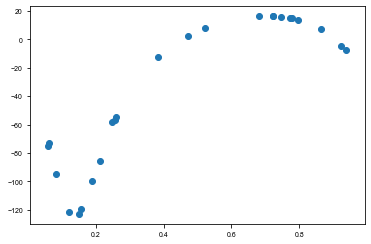

In [28]:
with pb2_model_RV:
    all_but = [v for v in pb2_model_RV.vars if v.name not in ["logP_interval__", "logasini_interval__"]]
    print(all_but)
    
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logs_lc, logs_rv_a])
    map_params = xo.optimize(start=map_params, vars=[gammav])
#     map_params = xo.optimize(start=map_params, vars=[phase, logamp])
    map_params = xo.optimize(start=map_params, vars=[eccen, omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[nu_pos, nu_neg])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    map_params = xo.optimize(start=map_params, vars=[asini_pos, asini_neg])
    map_params = xo.optimize(start=map_params, vars=all_but)

    map_params = xo.optimize(start=map_params, vars=[logP])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    plt.scatter(rv_jd_a % 15.33 / 15.33, xo.eval_in_model(rv_vrad_a, map_params))
#     map_params = xo.optimize(start=map_params)

Text(0, 0.5, 'RV (km/s)')

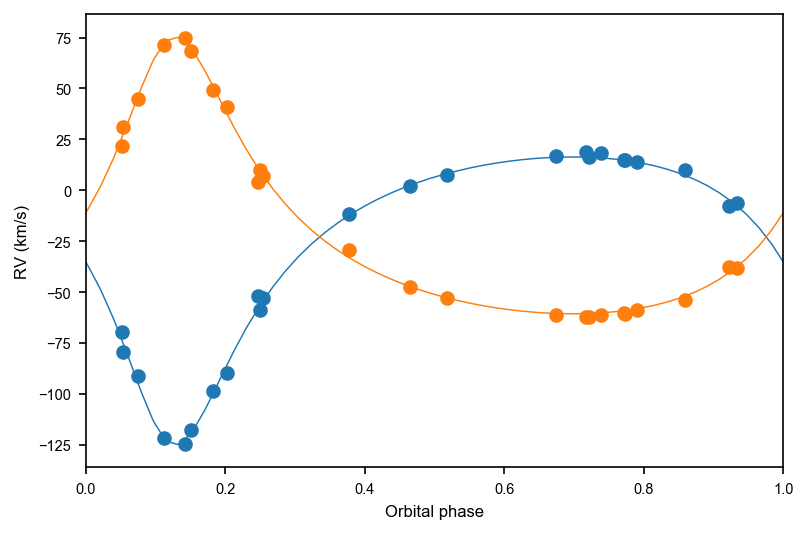

In [43]:
rv_time_tensor_a.set_value(np.linspace(rv_jd_a[0], rv_jd_a[-1], 1000))
rv_rv_tensor_a.set_value(np.linspace(rv_jd_a[0], rv_jd_a[-1], 1000))
rv_time_tensor_b.set_value(np.linspace(rv_jd_a[0], rv_jd_a[-1], 1000))
rv_rv_tensor_b.set_value(np.linspace(rv_jd_a[0], rv_jd_a[-1], 1000))

with pb2_model_RV:
    
    fold_time = rv_time_tensor_a.get_value() % map_params['period'] / map_params['period']
    sort = np.argsort(fold_time)
    plt.plot(fold_time[sort], xo.eval_in_model(rv_vrad_a, map_params)[sort], linewidth=0.7)
    plt.scatter(rv_jd_a % map_params['period'] / map_params['period'], rv_rv_a)
    
    plt.plot(fold_time[sort], xo.eval_in_model(rv_vrad_b, map_params)[sort], linewidth=0.7)
    plt.scatter(rv_jd_b % map_params['period'] / map_params['period'], rv_rv_b)
    
    
rv_time_tensor_a.set_value(rv_jd_a)
rv_rv_tensor_a.set_value(rv_rv_a)

rv_time_tensor_b.set_value(rv_jd_b)
rv_rv_tensor_b.set_value(rv_rv_b)

plt.xlim(0,1)
plt.xlabel('Orbital phase')
plt.ylabel('RV (km/s)')

Text(0, 0.5, 'RV (km/s)')

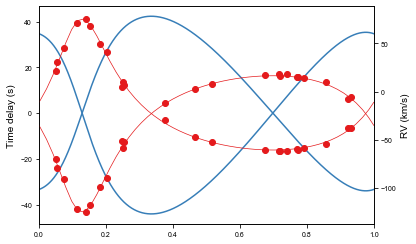

In [30]:
rv_time_tensor_a.set_value(np.linspace(rv_jd_a[0], rv_jd_a[-1], 1000))
rv_rv_tensor_a.set_value(np.linspace(rv_jd_a[0], rv_jd_a[-1], 1000))
rv_time_tensor_b.set_value(np.linspace(rv_jd_a[0], rv_jd_a[-1], 1000))
rv_rv_tensor_b.set_value(np.linspace(rv_jd_a[0], rv_jd_a[-1], 1000))

with pb2_model_RV:
    fold_time = time % map_params['period'] / map_params['period']
    sort = np.argsort(fold_time)
    
    td_pos = xo.eval_in_model(asini_pos * psi, map_params)
    td_neg = xo.eval_in_model(asini_neg * psi, map_params)
    
    plt.plot(fold_time[sort], td_pos[sort], c=blue)
    plt.plot(fold_time[sort], td_neg[sort], c=blue)
    plt.ylabel('Time delay (s)')
    
    ax2 = plt.twinx()
    fold_time = rv_time_tensor_a.get_value() % map_params['period'] / map_params['period']
    sort = np.argsort(fold_time)
    ax2.plot(fold_time[sort], xo.eval_in_model(rv_vrad_a, map_params)[sort], linewidth=0.7, c=red)
    ax2.scatter(rv_jd_a % map_params['period'] / map_params['period'], rv_rv_a, c=red)
    
    ax2.plot(fold_time[sort], xo.eval_in_model(rv_vrad_b, map_params)[sort], linewidth=0.7, c=red)
    ax2.scatter(rv_jd_b % map_params['period'] / map_params['period'], rv_rv_b, c=red)
    
rv_time_tensor_a.set_value(rv_jd_a)
rv_rv_tensor_a.set_value(rv_rv_a)

rv_time_tensor_b.set_value(rv_jd_b)
rv_rv_tensor_b.set_value(rv_rv_b)

ax2.set_xlim(0,1)
plt.xlabel('Orbital phase')
ax2.set_ylabel('RV (km/s)')



In [31]:
sampler = xo.PyMC3Sampler(window=200, finish=500)
with pb2_model_RV:
    burnin = sampler.tune(tune=1000, step_kwargs=dict(target_accept=0.9), start=map_params)

Sampling 2 chains: 100%|██████████| 1004/1004 [09:20<00:00,  1.36draws/s]


In [33]:
with pb2_model_RV:
    trace = sampler.sample(draws=1000)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [gammav, logs_RV_b, logs_RV_a, lognu_neg, lognu_pos, eccen, omega, mean, asini_neg, asini_pos, logs_lc, phi, logP]
Sampling 2 chains: 100%|██████████| 2000/2000 [19:37<00:00,  1.26draws/s]


In [34]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logs_lc,1.505374,2.791965e-03,5.074587e-05,1.499990,1.510728,3196.340603,0.999706
asini_pos,44.939928,1.859542e-01,3.730975e-03,44.601160,45.320801,2232.433828,1.003734
asini_neg,-43.164430,1.459248e-01,2.753235e-03,-43.448645,-42.882756,2541.981270,0.999571
mean,-0.000251,1.773215e-02,3.212764e-04,-0.035832,0.033215,3216.097312,0.999866
lognu_pos__0,2.635306,4.902410e-07,9.115598e-09,2.635305,2.635307,2752.307907,0.999522
lognu_pos__1,2.653477,1.992874e-06,3.438912e-08,2.653473,2.653481,3053.138780,0.999506
lognu_neg__0,2.752598,4.675916e-07,9.811853e-09,2.752598,2.752599,2820.092555,0.999541
lognu_neg__1,2.521927,8.056798e-07,1.400438e-08,2.521926,2.521929,3137.253595,0.999674
lognu_neg__2,2.556494,9.788879e-07,1.822999e-08,2.556492,2.556496,3193.144832,0.999993
lognu_neg__3,2.850998,8.970943e-07,1.743723e-08,2.850996,2.851000,3013.964584,0.999838


In [18]:
with pb2_model_RV:
    trace = pm.load_trace('traces/10080943_rv')

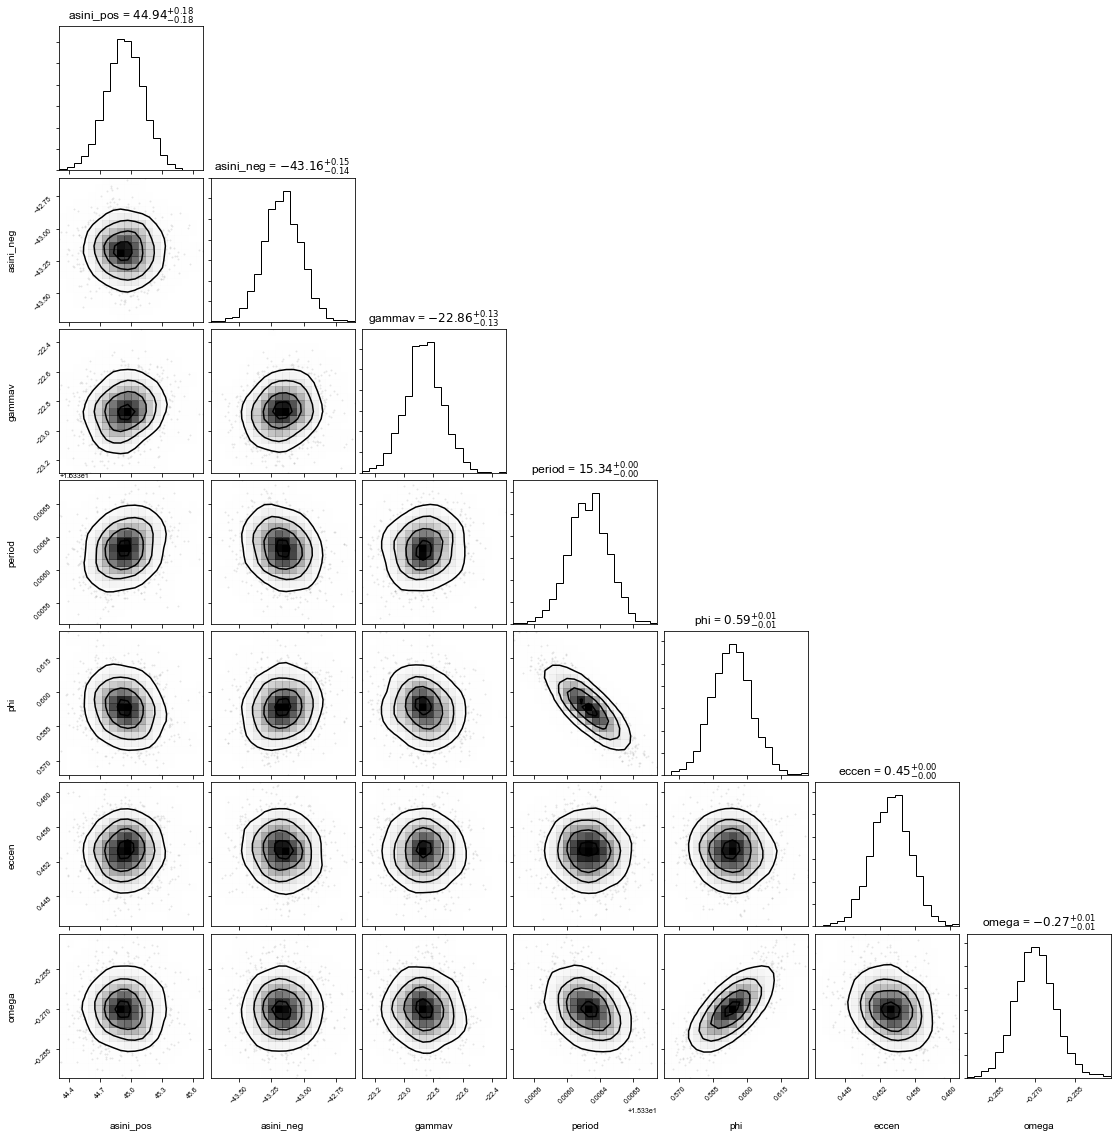

In [19]:
import corner

corner.corner(pm.trace_to_dataframe(trace, 
                                    varnames=['asini_pos', 'asini_neg', 'gammav','period','phi','eccen','omega']),
             smooth=1,
             show_titles=True);

# plt.savefig('10080943.png', dpi=300,bbox_inches='tight')

In [20]:
from maelstrom.utils import mass_function
import astropy.units as u
rounding = 3
samples = pm.trace_to_dataframe(trace, varnames=['period', 'asini_pos'])
mfs = mass_function(samples['period'].values * u.day, samples['asini_pos'].values*u.s)
#mfs = np.array(mfs)
upper, med, lower = np.percentile(mfs.value, [84.13, 50, 15.86])
print('mass_func', ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

mass_func :  0.414  +  0.005  -  0.005


In [21]:
varnames=['period', 'asini_pos','asini_neg', 'phi', 'eccen', 'omega','gammav']
rounding = 4
for varname in varnames:
    upper, med, lower = np.percentile(trace[varname], [84.13, 50, 15.86])
    print(varname, ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

period :  15.3363  +  0.0002  -  0.0002
asini_pos :  44.9399  +  0.1817  -  0.1792
asini_neg :  -43.1641  +  0.1465  -  0.1441
phi :  0.5933  +  0.0084  -  0.0088
eccen :  0.4532  +  0.0023  -  0.0022
omega :  -0.2701  +  0.0076  -  0.0075
gammav :  -22.8639  +  0.1282  -  0.1298


In [28]:
with pb2_model_RV:
    a = xo.eval_in_model(asini_pos * psi)

In [27]:
samp

{'logP_interval__': -0.05302221292474968,
 'phi_angle__': array([2.38077305, 3.50810861]),
 'logs_lc': 1.503106224196015,
 'asini_pos': 44.947949539218946,
 'asini_neg': -43.173468198233785,
 'mean': 0.003932298023283192,
 'omega_angle__': array([-1.33818057,  4.99958407]),
 'eccen_interval__': -0.19096305685863374,
 'lognu_pos': array([2.63530587, 2.65347761]),
 'lognu_neg': array([2.75259784, 2.52192862, 2.55649459, 2.85099771]),
 'logs_RV_a': 0.11236832140087478,
 'logs_RV_b': -0.3777195088913156,
 'gammav': -22.825830993916206,
 'logP': 2.7302155683426648,
 'period': 15.336192661233353,
 'phi': 0.5962519902387579,
 'omega': -0.2615280360501543,
 'eccen': 0.45195138464403606,
 'nu_pos': array([13.94757791, 14.20334656]),
 'nu_neg': array([15.68332182, 12.45258985, 12.89055135, 17.3050386 ])}

TypeError: ('Bad input argument to theano function with name "/Users/danielhey/anaconda3/lib/python3.7/site-packages/exoplanet/utils.py:46" at index 8 (0-based). ', 'Non-unit value on shape on a broadcastable dimension.', (2,), (True,))

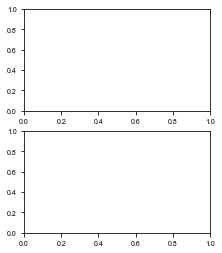

In [22]:
rv_time_tensor_a.set_value(np.linspace(rv_jd_a[0], rv_jd_a[-1], 1000))
rv_rv_tensor_a.set_value(np.linspace(rv_jd_a[0], rv_jd_a[-1], 1000))
rv_time_tensor_b.set_value(np.linspace(rv_jd_a[0], rv_jd_a[-1], 1000))
rv_rv_tensor_b.set_value(np.linspace(rv_jd_a[0], rv_jd_a[-1], 1000))

fig, axes = plt.subplots(2,1, figsize=[3.33333,2*2.06])

with pb2_model_RV:
    for samp in xo.utils.get_samples_from_trace(trace, size=300):
        taumod_pos = xo.eval_in_model(asini_pos * psi, samp)
        taumod_neg = xo.eval_in_model(asini_neg * psi, samp)
        ttime = (time) % samp['period'] / samp['period']
        
        sort = np.argsort(ttime)
        
        ax = axes[0]
        ax.plot(ttime[sort], (taumod_pos - np.mean(taumod_pos))[sort], color=blue, linewidth=0.1, alpha=1, rasterized=True, zorder=1)
        ax.plot(ttime[sort], (taumod_neg - np.mean(taumod_neg))[sort], color=orange, linewidth=0.1, alpha=1, rasterized=True, zorder=1)
        
        ax = axes[1]
        fold_time = rv_time_tensor_a.get_value() % samp['period'] / samp['period']
        sort = np.argsort(fold_time)
        ax.plot(fold_time[sort], xo.eval_in_model(rv_vrad_a, samp)[sort], linewidth=0.1, color=blue)

        ax.plot(fold_time[sort], xo.eval_in_model(rv_vrad_b, samp)[sort], linewidth=0.1, color=orange)
        
ax.plot(rv_jd_b % samp['period'] / samp['period'], rv_rv_b, '.k', c=[0.91372549, 0.36862745, 0.05098039])
ax.plot(rv_jd_a % samp['period'] / samp['period'], rv_rv_a, '.k',  c=[0.21568627, 0.52941176, 0.75424837])

axes[1].set_xlabel('Orbital phase')
axes[0].set_ylabel('Time delay (s)')
axes[1].set_ylabel('RV (km/s)')
axes[0].set_xticks([])

axes[0].set_xlim(0, 1)
axes[1].set_xlim(0, 1)

plt.subplots_adjust(hspace=0.03)
# plt.savefig(overleaf_path + '10080943.png', dpi=300, bbox_inches='tight', pad_inches=0)

rv_time_tensor_a.set_value(rv_jd_a)
rv_rv_tensor_a.set_value(rv_rv_a)

rv_time_tensor_b.set_value(rv_jd_b)
rv_rv_tensor_b.set_value(rv_rv_b)

In [96]:
unique_colors(2, cmap='Blues')

array([[0.67189542, 0.81437908, 0.90065359],
       [0.21568627, 0.52941176, 0.75424837]])

In [95]:
orange

'#ff7f00'

In [68]:
rv_time_tensor_a.set_value(np.linspace(rv_jd_a[0], rv_jd_a[-1], 1000))
rv_rv_tensor_a.set_value(np.linspace(rv_jd_a[0], rv_jd_a[-1], 1000))
rv_time_tensor_b.set_value(np.linspace(rv_jd_a[0], rv_jd_a[-1], 1000))
rv_rv_tensor_b.set_value(np.linspace(rv_jd_a[0], rv_jd_a[-1], 1000))

with pb2_model_RV:
    
    fold_time = rv_time_tensor_a.get_value() % map_params['period'] / map_params['period']
    sort = np.argsort(fold_time)
    plt.plot(fold_time[sort], xo.eval_in_model(rv_vrad_a, map_params)[sort], linewidth=0.7)
    plt.scatter(rv_jd_a % map_params['period'] / map_params['period'], rv_rv_a)
    
    plt.plot(fold_time[sort], xo.eval_in_model(rv_vrad_b, map_params)[sort], linewidth=0.7)
    plt.scatter(rv_jd_b % map_params['period'] / map_params['period'], rv_rv_b)
    
    
rv_time_tensor_a.set_value(rv_jd_a)
rv_rv_tensor_a.set_value(rv_rv_a)

rv_time_tensor_b.set_value(rv_jd_b)
rv_rv_tensor_b.set_value(rv_rv_b)

<Quantity 3086663.147568 km>